# **Semantic segmentation**


Created a semantic segmentation(colon cancer segmentation) model using Tensorflow that determines the region of the disease looking at the 3D medical image provided.

<!--
Utilize Transfer learning to train the model faster

Train and validate the model on 2D images (converted from 3D)

Demonstrate by inferencing on both 2D images and 3D images.

Keep the latency of the model (forward pass) less than 250ms on the GPU provided on Colab (Nvidia T4)
-->

**Dataset**  http://medicaldecathlon.com/

#Dataset Features

The dataset in in *.nii.gz extension.

The data format is NIFTI ((Neuroimaging Informatics Technology Initiative) which is used for the storage of Functional Magnetic Resonance Imaging (fMRI) and other medical images.

NIfTI images are registered in a local coordinate system.

It is a 3-dimensional (3D) array : where individual slices are stacked on top of each other.

# Importing libraries

In [1]:
!pip install nibabel==2.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 7.7 MB/s 
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


In [2]:
!pip install scikit-learn==0.20.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.4 MB 7.2 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.20.3 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.20.3 which is incompatible.


In [1]:
!pip install niwidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.5 MB 6.4 MB/s 
     |████████████████████████████████| 2.3 MB 43.2 MB/s 
     |████████████████████████████████| 2.9 MB 48.3 MB/s 
     |████████████████████████████████| 260 kB 68.7 MB/s 
     |████████████████████████████████| 3.3 MB 46.2 MB/s 
     |████████████████████████████████| 1.6 MB 50.0 MB/s 
     |████████████████████████████████| 271 kB 67.8 MB/s 


In [2]:
from niwidgets import NiftiWidget
import nibabel as nib

In [3]:
#importing required libraries
import numpy as np 
import pandas as pd 
import os,time
import warnings
warnings.filterwarnings('ignore')

In [4]:
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from itertools import chain
from tqdm import tqdm_notebook,tnrange
from glob import glob
from skimage.io import imread, imshow,concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Downloading the Dataset

## Mounting the drive containing the dataset

In [5]:
#mounting drive where the data is stored
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Extracting tar file

In [6]:
#import module
import tarfile

with tarfile.open("/content/drive/MyDrive/Task10_Colon.tar","r") as tr:
    print("Opened tarfile")
    tr.extractall(path="./content/drive/MyDrive/project") #extraction of tar file
    print("All files extracted")

Opened tarfile
All files extracted


# Dataset visualization

In [7]:
#file path
image_path = '/content/content/drive/MyDrive/project/Task10_Colon/imagesTr'
masks_path = '/content/content/drive/MyDrive/project/Task10_Colon/labelsTr'


In [8]:
def file_name(path):
  files = []
  for f in os.listdir(path):
    files.append(f)
  return files

In [9]:
images = file_name(image_path)
masks = file_name(masks_path)

In [10]:
len(images), len(masks)

(252, 252)

## Converting the images and masks to dataframe

In [11]:
imagemask_df = pd.DataFrame({'images':images,'masks':masks})
imagemask_df.head()

,images,masks
0,._colon_165.nii.gz,._colon_165.nii.gz
1,colon_100.nii.gz,colon_100.nii.gz
2,._colon_157.nii.gz,._colon_157.nii.gz
3,._colon_169.nii.gz,._colon_169.nii.gz
4,colon_038.nii.gz,colon_038.nii.gz


In [12]:
imagemask_df['images'][0]

'._colon_165.nii.gz'

In [13]:
imgTargetNii = nib.load("/content/content/drive/MyDrive/project/Task10_Colon/imagesTr/colon_001.nii.gz")
imgMaskNii  = nib.load("/content/content/drive/MyDrive/project/Task10_Colon/labelsTr/colon_001.nii.gz")


##3d data visualization

In [14]:
my_widget = NiftiWidget(imgTargetNii)
my_widget.nifti_plotter(colormap='gray')

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=255, continuous_update=False, description='x', max=511), IntSlider(value…

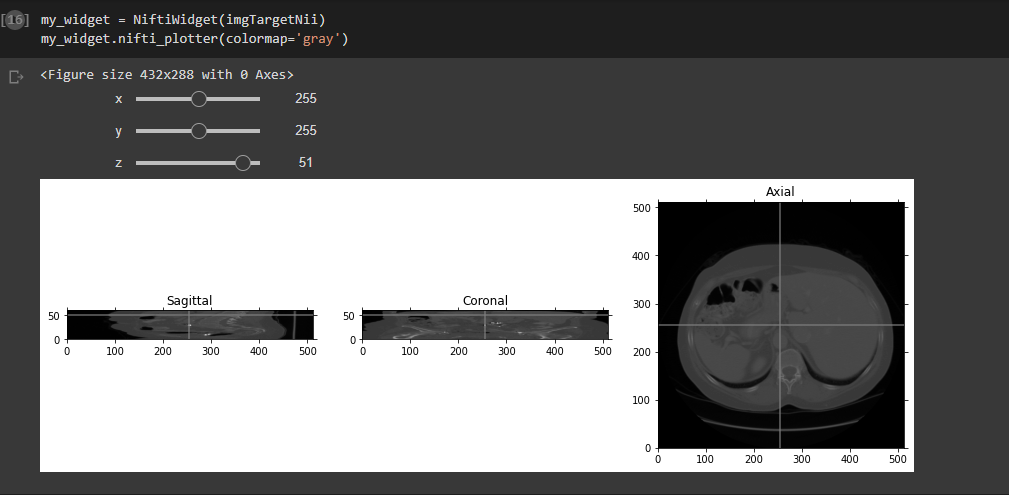

In [ ]:
from IPython.display import Image
Image(filename='imgTargetNii.PNG')

In [15]:
my_widget = NiftiWidget(imgMaskNii)
my_widget.nifti_plotter(colormap='gray')

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=255, continuous_update=False, description='x', max=511), IntSlider(value…

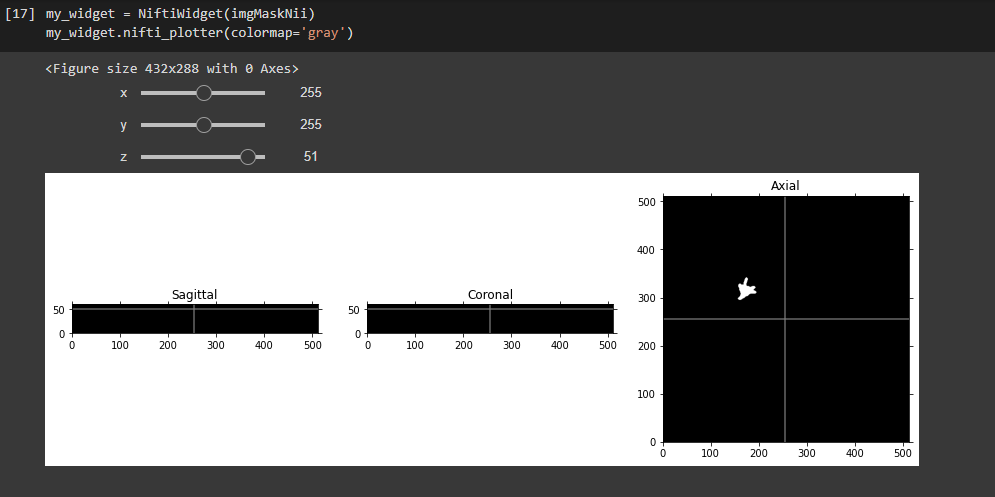

In [ ]:
from IPython.display import Image
Image(filename='imgMaskNii.PNG')

## Normalizing the *data*

In [16]:
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [17]:
# Load image and see max min Hounsfield units
imgPath = os.path.join(image_path, '/content/content/drive/MyDrive/project/Task10_Colon/imagesTr/colon_001.nii.gz')
img = nib.load(imgPath).get_fdata()
np.min(img), np.max(img), img.shape, type(img)

(-1024.0, 3072.0, (512, 512, 60), numpy.ndarray)

In [18]:

# Load image mask and see max min Hounsfield units
maskPath = os.path.join(masks_path, '/content/content/drive/MyDrive/project/Task10_Colon/labelsTr/colon_001.nii.gz')
mask = nib.load(maskPath).get_fdata()
np.min(mask), np.max(mask), mask.shape, type(mask)

(0.0, 1.0, (512, 512, 60), numpy.ndarray)

In [19]:
#Image normalization
HOUNSFIELD_MIN = -1024
HOUNSFIELD_MAX = 3072
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

SLICE_Z = True

SLICE_DECIMATE_IDENTIFIER = 3

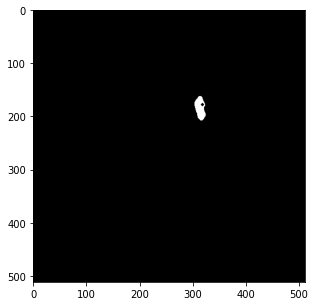

In [20]:
# Show image slice
imgSlice = mask[:,:,52]
plt.figure(figsize = (30,5))
plt.imshow(imgSlice, cmap='gray')
plt.show()

In [21]:
# Normalize image
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

nImg = normalizeImageIntensityRange(img)
np.min(nImg), np.max(nImg), nImg.shape, type(nImg)

(0.0, 1.0, (512, 512, 60), numpy.ndarray)

In [22]:
# Read image or mask volume
def readImageVolume(imgPath, normalize=False):
    img = nib.load(imgPath).get_fdata()
    if normalize:
        return normalizeImageIntensityRange(img)
    else:
        return img
    
readImageVolume(imgPath, normalize=True)
readImageVolume(maskPath, normalize=True)

array([[[0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        ...,
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        ...,
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        ...,
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25]],

       ...,

       [[0.25, 0.25, 0.2

## Data slicing

In [23]:
#slice path
!mkdir /content/imageslice /content/maskslice /content/testimageslice /content/temp


imageSliceOutput = '/content/imageslice/'
maskSliceOutput = '/content/maskslice/'
test_imageSliceOutput = '/content/testimageslice/'

In [24]:
#function to save the slices img
def saveImageSlice(image, filename, path, mul=True):
  if mul:
    img = np.uint8(image * 255)
  else:
    img = np.uint8(image)
  fout = os.path.join(path, f'{filename}.png')
  cv2.imwrite(fout, img)
  print(f'[+] Slice saved: {fout}', end='\r')

In [25]:
# Slice image in z direction and save
def sliceAndSaveVolumeImage(vol, filename, path, mul=True):
  (dimx, dimy, dimz) = vol.shape
  print(dimx, dimy, dimz)
  cnt = 0 
  cnt += dimz
  for i in range(dimz):
      saveImageSlice(vol[:,:,i], filename+f'-slice{str(i).zfill(3)}', path, mul)
  return cnt

###  slicing on train image data

In [26]:
# Read and process image volumes
imagePathInput = '/content/content/drive/MyDrive/project/Task10_Colon/imagesTr'
for index, filename in enumerate(sorted(glob.glob('/content/content/drive/MyDrive/project/Task10_Colon/imagesTr/*.nii.gz'))):
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'colon'+str(index), imageSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

/content/content/drive/MyDrive/project/Task10_Colon/imagesTr/colon_001.nii.gz (512, 512, 60) 1084 0.0 1.0
512 512 60
[+] Slice saved: /content/imageslice/colon0-slice059.png
/content/content/drive/MyDrive/project/Task10_Colon/imagesTr/colon_001.nii.gz, 60 slices created 

/content/content/drive/MyDrive/project/Task10_Colon/imagesTr/colon_005.nii.gz (512, 512, 98) 1122 0.0 0.59521484375
512 512 98
[+] Slice saved: /content/imageslice/colon1-slice097.png
/content/content/drive/MyDrive/project/Task10_Colon/imagesTr/colon_005.nii.gz, 98 slices created 

/content/content/drive/MyDrive/project/Task10_Colon/imagesTr/colon_006.nii.gz (512, 512, 68) 1092 0.0 0.601318359375
512 512 68
[+] Slice saved: /content/imageslice/colon2-slice067.png
/content/content/drive/MyDrive/project/Task10_Colon/imagesTr/colon_006.nii.gz, 68 slices created 

/content/content/drive/MyDrive/project/Task10_Colon/imagesTr/colon_007.nii.gz (512, 512, 74) 1098 0.0 0.528564453125
512 512 74
[+] Slice saved: /content/images

###  slicing on train mask data

In [27]:
# Read and process image mask volumes
maskPathInput = '/content/content/drive/MyDrive/project/Task10_Colon/labelsTr'
for index, filename in enumerate(sorted(glob.glob('/content/content/drive/MyDrive/project/Task10_Colon/labelsTr/*.nii.gz'))):
    img = readImageVolume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'colon'+str(index), maskSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

/content/content/drive/MyDrive/project/Task10_Colon/labelsTr/colon_001.nii.gz (512, 512, 60) 1084 0.0 1.0
512 512 60
[+] Slice saved: /content/maskslice/colon0-slice059.png
/content/content/drive/MyDrive/project/Task10_Colon/labelsTr/colon_001.nii.gz, 60 slices created 

/content/content/drive/MyDrive/project/Task10_Colon/labelsTr/colon_005.nii.gz (512, 512, 98) 1122 0.0 1.0
512 512 98
[+] Slice saved: /content/maskslice/colon1-slice097.png
/content/content/drive/MyDrive/project/Task10_Colon/labelsTr/colon_005.nii.gz, 98 slices created 

/content/content/drive/MyDrive/project/Task10_Colon/labelsTr/colon_006.nii.gz (512, 512, 68) 1092 0.0 1.0
512 512 68
[+] Slice saved: /content/maskslice/colon2-slice067.png
/content/content/drive/MyDrive/project/Task10_Colon/labelsTr/colon_006.nii.gz, 68 slices created 

/content/content/drive/MyDrive/project/Task10_Colon/labelsTr/colon_007.nii.gz (512, 512, 74) 1098 0.0 1.0
512 512 74
[+] Slice saved: /content/maskslice/colon3-slice073.png
/content/co

###  slicing on test image data

In [28]:
# Read and process image volumes
imagePathInput = '/content/content/drive/MyDrive/project/Task10_Colon/imagesTs'
for index, filename in enumerate(sorted(glob.glob('/content/content/drive/MyDrive/project/Task10_Colon/imagesTs/*.nii.gz'))):
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'colon'+str(index), test_imageSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

/content/content/drive/MyDrive/project/Task10_Colon/imagesTs/colon_003.nii.gz (512, 512, 127) 1151 0.0 0.999755859375
512 512 127
[+] Slice saved: /content/testimageslice/colon0-slice126.png
/content/content/drive/MyDrive/project/Task10_Colon/imagesTs/colon_003.nii.gz, 127 slices created 

/content/content/drive/MyDrive/project/Task10_Colon/imagesTs/colon_004.nii.gz (512, 512, 185) 1209 0.005859375 1.0
512 512 185
[+] Slice saved: /content/testimageslice/colon1-slice184.png
/content/content/drive/MyDrive/project/Task10_Colon/imagesTs/colon_004.nii.gz, 185 slices created 

/content/content/drive/MyDrive/project/Task10_Colon/imagesTs/colon_010.nii.gz (512, 512, 64) 1088 0.0 0.5859375
512 512 64
[+] Slice saved: /content/testimageslice/colon2-slice063.png
/content/content/drive/MyDrive/project/Task10_Colon/imagesTs/colon_010.nii.gz, 64 slices created 

/content/content/drive/MyDrive/project/Task10_Colon/imagesTs/colon_013.nii.gz (512, 512, 92) 1116 0.005859375 0.66552734375
512 512 92
[+]

## Converting the sliced images and mask to dataframe

In [29]:
#slice path
image_slicepath = '/content/imageslice'
masks_slicepath = '/content/maskslice'
test_imageSliceOutput = '/content/testimageslice/'

In [30]:
def file_name(path):
  files = []
  for f in os.listdir(path):
    files.append(f)
  return files

In [31]:
slice_images = file_name(image_slicepath)
slice_masks = file_name(masks_slicepath)
slice_test_images = file_name(test_imageSliceOutput)


In [32]:
len(slice_images), len(slice_masks) , len(slice_test_images)

(13486, 13486, 6616)

In [33]:
imagemask_df = pd.DataFrame({'slice_images':slice_images,'slice_masks':slice_masks})
imagemask_df.head()

,slice_images,slice_masks
0,colon28-slice008.png,colon28-slice008.png
1,colon45-slice034.png,colon45-slice034.png
2,colon102-slice034.png,colon102-slice034.png
3,colon77-slice007.png,colon77-slice007.png
4,colon30-slice050.png,colon30-slice050.png


In [34]:
imagemask_df['slice_images'][0]

'colon28-slice008.png'

In [35]:
test_image_df = pd.DataFrame({'slice_test_images':slice_test_images})
test_image_df.head()

,slice_test_images
0,colon26-slice099.png
1,colon28-slice008.png
2,colon45-slice034.png
3,colon30-slice050.png
4,colon19-slice015.png


now the image format is sliced and converted from .nii.gz to .png file and saved in the path provided

## Sliced data visualization of images and Masks

In [36]:
#Shape of Images and masks
def print_imShape(df, image_path, masks_path):
  idx = random.randint(0,len(slice_images))
  image = cv2.imread(image_slicepath +'/'+ df['slice_images'][idx])
  mask = cv2.imread(masks_slicepath +'/'+ df['slice_masks'][idx])
    
  print("Image shape:",image.shape)
  print("Mask shape:",mask.shape)

In [37]:
for i in range(5):
  print_imShape(imagemask_df, image_slicepath, masks_slicepath)

Image shape: (512, 512, 3)
Mask shape: (512, 512, 3)
Image shape: (512, 512, 3)
Mask shape: (512, 512, 3)
Image shape: (512, 512, 3)
Mask shape: (512, 512, 3)
Image shape: (512, 512, 3)
Mask shape: (512, 512, 3)
Image shape: (512, 512, 3)
Mask shape: (512, 512, 3)


**Visualizing the sliced data**

In [38]:
def plot_images(df, image_path, masks_path):
    
  idx = random.randint(0,len(imagemask_df))
    
  image = cv2.imread(image_slicepath +'/'+ df['slice_images'][idx])
  mask = cv2.imread(masks_slicepath +'/'+ df['slice_masks'][idx])
    
  fig, axs = plt.subplots(1,3, figsize=[13,15])
    
  axs[0].imshow(image)
  axs[0].set_title("Colon Cancer Slice")
    
  plt.grid(False)
    
  axs[1].imshow(mask)
  axs[1].set_title('Mask')
    
  plt.grid(False)
    
  axs[2].imshow(image)
  axs[2].imshow(mask, alpha=0.3)
  axs[2].set_title('Cancer with mask')
    
  plt.grid(False)
  plt.show()


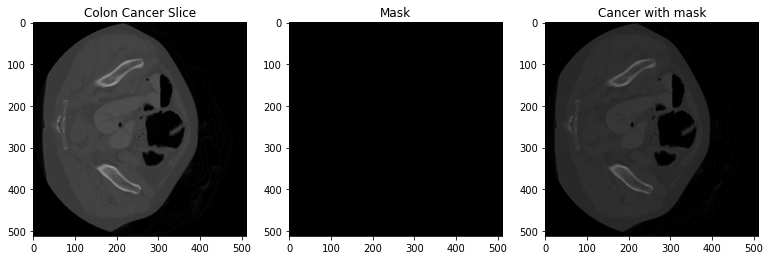

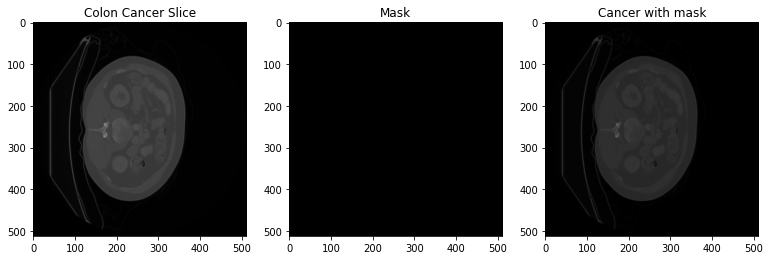

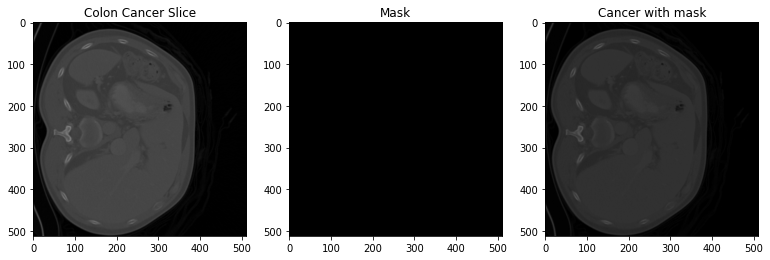

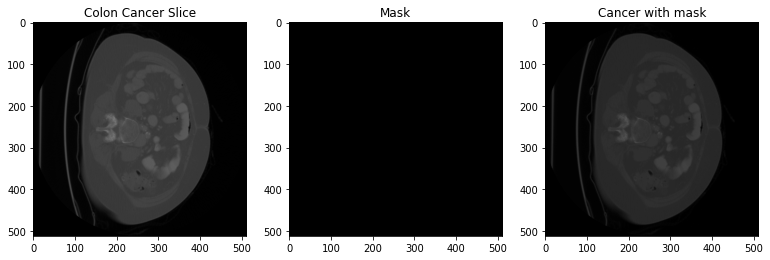

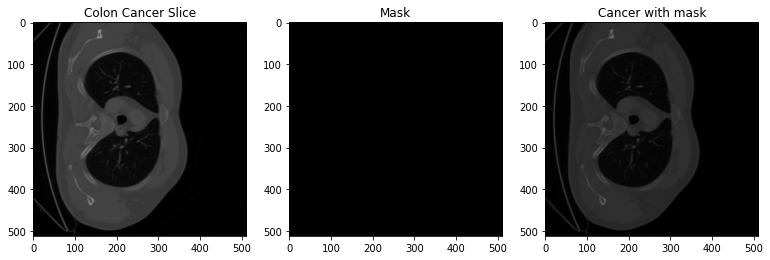

In [39]:
for i in range(5):
  plot_images(imagemask_df, image_slicepath, masks_slicepath)

In [40]:
#Creating dataframe of images and its corresponding masks
imgMask_path = pd.DataFrame({'image-path':image_slicepath+'/'+ imagemask_df['slice_images'],
                             'mask-path':masks_slicepath+'/'+ imagemask_df['slice_masks']})
imgMask_path.head()

,image-path,mask-path
0,/content/imageslice/colon28-slice008.png,/content/maskslice/colon28-slice008.png
1,/content/imageslice/colon45-slice034.png,/content/maskslice/colon45-slice034.png
2,/content/imageslice/colon102-slice034.png,/content/maskslice/colon102-slice034.png
3,/content/imageslice/colon77-slice007.png,/content/maskslice/colon77-slice007.png
4,/content/imageslice/colon30-slice050.png,/content/maskslice/colon30-slice050.png


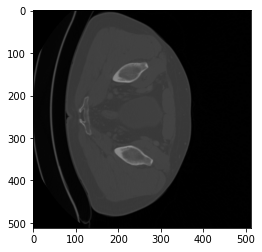

In [41]:
plt.imshow(cv2.imread(imgMask_path['image-path'][12]))

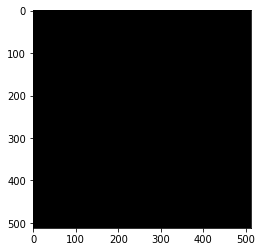

In [42]:
plt.imshow(cv2.imread(imgMask_path['mask-path'][12]))

# Data augmentation and preprocess

In [43]:
#train test split
train, test = train_test_split(imgMask_path,test_size=0.25, random_state=21)

In [44]:
len(train), len(test)

(10114, 3372)

## Data augmentation

In [45]:
EPOCHS = 30
BATCH_SIZE = 64
ImgHeight = 256
ImgWidth = 256
Channels = 3

In [46]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

## Dataset into train and validation data

In [47]:
imagegen = ImageDataGenerator(rescale=1./255., **data_augmentation)
maskgen = ImageDataGenerator(rescale=1./255., **data_augmentation)


# train generator
timage_generator=imagegen.flow_from_dataframe(dataframe=train,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHeight,ImgWidth),
                                            color_mode='rgb')
# mask train generator
tmask_generator=maskgen.flow_from_dataframe(dataframe=train,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHeight,ImgWidth),
                                            color_mode='grayscale')  

Found 10114 validated image filenames.
Found 10114 validated image filenames.


In [48]:
imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)

#vlidation images generator
vimage_generator = imagegen.flow_from_dataframe(dataframe=test,
                                             x_col = "image-path",
                                             batch_size = BATCH_SIZE,
                                             seed=42,
                                             class_mode=None,
                                             target_size = (ImgHeight,ImgWidth),
                                             color_mode='rgb')
# validation masks generator
vmask_generator = maskgen.flow_from_dataframe(dataframe=test,
                                             x_col = "mask-path",
                                             batch_size = BATCH_SIZE,
                                             seed=42,
                                             class_mode=None,
                                             target_size = (ImgHeight,ImgWidth),
                                             color_mode='grayscale')

Found 3372 validated image filenames.
Found 3372 validated image filenames.


In [49]:
def data_iterator(image_gen,mask_gen):
  for img, mask in zip(image_gen,mask_gen):
      yield img, mask

In [50]:
train_gen = data_iterator(timage_generator, tmask_generator)
val_gen = data_iterator(vimage_generator,vmask_generator)

# Defining different metrices

**We checked our model on different metrices to evaluate its performance better**

In [51]:
def iou(ytrue, ypred):
    smoothing_factor=0.1
    intersection = K.sum(ytrue*ypred)
    combined_area = K.sum(ytrue+ypred)
    union_area = combined_area - intersection
    iou = (intersection+smoothing_factor)/(union_area+smoothing_factor)
    return iou

def jac_distance(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    return -iou(y_true, y_pred)

# Dice Sorenson
def dice_coef(ytrue, ypred):
    smoothing_factor=0.1
    ytrue_f = K.flatten(ytrue)
    ypred_f = K.flatten(ypred)
    intersection = K.sum(ytrue*ypred)
    ytrue_area = K.sum(ytrue)
    ypred_area = K.sum(ypred)
    combined_area = ytrue_area + ypred_area
    dice = 2*((intersection+smoothing_factor)/(combined_area+smoothing_factor))
    return dice

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [52]:
STEP_SIZE_TRAIN = timage_generator.n/BATCH_SIZE
STEP_SIZE_VALID = vimage_generator.n/BATCH_SIZE

# Model making

## Importing the pretrained segmentation model library 

In [53]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.3 MB/s 


## Model Resnet50 model

In [54]:
import imageio
import tensorflow as tf
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

creating list of the images

In [55]:
image_list = os.listdir(image_slicepath)
mask_list = os.listdir(masks_slicepath)

image_list = [image_slicepath+i for i in image_list]
mask_list = [masks_slicepath+i for i in mask_list]

In [56]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)
#Creating tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/imageslicecolon28-slice008.png', shape=(), dtype=string)
tf.Tensor(b'/content/maskslicecolon28-slice008.png', shape=(), dtype=string)


In [57]:
tf.data.experimental.cardinality(dataset)

<tf.Tensor: shape=(), dtype=int64, numpy=13486>

### Importing the model

In [ ]:
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

### Compiling the model

In [ ]:
model_2 = sm.Unet(BACKBONE, encoder_weights='imagenet') #weights were assigned using imagenet
model_2.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", iou, dice_coef,tf.keras.metrics.Precision()])
print(model_2.summary())

94592056/94592056 [==============================] - 15s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                          

In [62]:
my_model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", iou, dice_coef,tf.keras.metrics.Precision()])

### Train model

In [65]:
callbacks_2 = [
    EarlyStopping(patience=6, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=1e-6, verbose=1),
    ModelCheckpoint('/content/model2.h5', verbose=1, save_best_only=True, save_weights_only=True)
] #model is saved in the path given above

In [95]:
#model training
resnet_results = my_model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=10,
                    callbacks=callbacks_2,
                    validation_data=val_gen,
                   validation_steps=STEP_SIZE_VALID)

Epoch 1/10
159/158 [==============================] - ETA: -1s - loss: 8.4250e-04 - accuracy: 0.9996 - iou: 0.3538 - dice_coef: 0.5100 - precision: 0.8379
Epoch 1: val_loss did not improve from 0.00125
158/158 [==============================] - 330s 2s/step - loss: 8.4250e-04 - accuracy: 0.9996 - iou: 0.3538 - dice_coef: 0.5100 - precision: 0.8379 - val_loss: 0.0020 - val_accuracy: 0.9995 - val_iou: 0.1147 - val_dice_coef: 0.1957 - val_precision: 0.9552 - lr: 1.0000e-04
Epoch 2/10
159/158 [==============================] - ETA: -1s - loss: 8.8031e-04 - accuracy: 0.9996 - iou: 0.3348 - dice_coef: 0.4865 - precision: 0.8326
Epoch 2: val_loss did not improve from 0.00125
158/158 [==============================] - 332s 2s/step - loss: 8.8031e-04 - accuracy: 0.9996 - iou: 0.3348 - dice_coef: 0.4865 - precision: 0.8326 - val_loss: 0.0013 - val_accuracy: 0.9996 - val_iou: 0.3010 - val_dice_coef: 0.4464 - val_precision: 0.8773 - lr: 1.0000e-04
Epoch 3/10
159/158 [==============================

###Saving and Loading the model

In [96]:
my_model.save("model4")


In [59]:
!cp /content/drive/MyDrive/model.zip /content

In [98]:
!cp model4.zip /content/drive/MyDrive

In [60]:
!unzip model.zip 

Archive:  model.zip
   creating: content/model/
   creating: content/model/assets/
  inflating: content/model/saved_model.pb  
  inflating: content/model/keras_metadata.pb  
   creating: content/model/variables/
  inflating: content/model/variables/variables.index  
  inflating: content/model/variables/variables.data-00000-of-00001  


In [97]:
!zip -r model4.zip /content/model4

  adding: content/model4/ (stored 0%)
  adding: content/model4/assets/ (stored 0%)
  adding: content/model4/saved_model.pb (deflated 92%)
  adding: content/model4/keras_metadata.pb (deflated 96%)
  adding: content/model4/variables/ (stored 0%)
  adding: content/model4/variables/variables.index (deflated 80%)
  adding: content/model4/variables/variables.data-00000-of-00001 (deflated 12%)


In [121]:
m_model = load_model("/content/model4",custom_objects={'iou':iou,'dice_coef':dice_coef})

#Visualizing Model Performance

## Epochs vs different metrics

In [99]:
def show_graph_resnet(history):
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  dice_train = history.history['dice_coef']
  dice_val = history.history['val_dice_coef']
  iou_train = history.history['iou']
  iou_val = history.history['val_iou']
  precision_train = history.history['precision']
  precision_val = history.history['val_precision']
  epochs = range(len(loss_train))
  

  plt.figure(figsize=(18,12))
  plt.subplot(2,2,1)
  plt.plot(epochs, loss_train, 'r', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(2,2,2)
  plt.plot(epochs, dice_train, 'r', label='Training Dice')
  plt.plot(epochs, dice_val, 'b', label='validation Dice')
  plt.title('Training and Validation Dice Co-efficient')
  plt.xlabel('Epochs')
  plt.ylabel('Dice Co-efficient')
  plt.legend()

  plt.subplot(2,2,3)
  plt.plot(epochs, iou_train, 'r', label='Training IOU')
  plt.plot(epochs, iou_val, 'b', label='validation IOU')
  plt.title('Training and Validation IOU')
  plt.xlabel('Epochs')
  plt.ylabel('IOU')
  plt.legend()

  plt.subplot(2,2,4)
  plt.plot(epochs, precision_train, 'r', label='Training Precision')
  plt.plot(epochs, precision_val, 'b', label='validation Precision')
  plt.title('Training and Validation Precision')
  plt.xlabel('Epochs')
  plt.ylabel('Precision')
  plt.legend()
  plt.show()

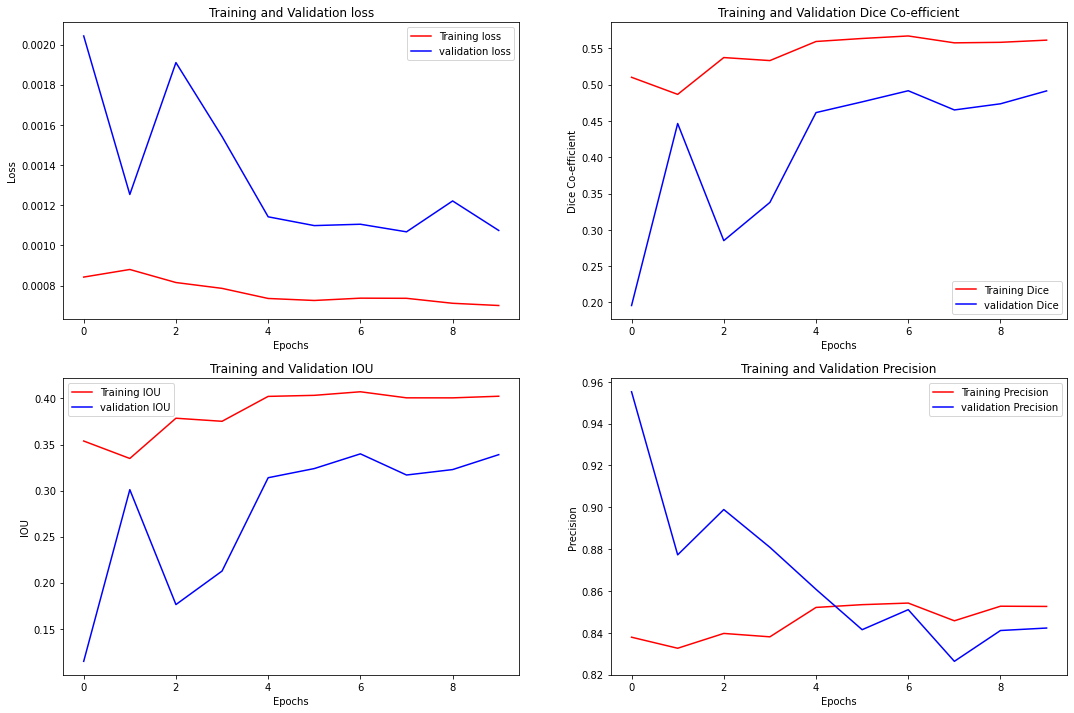

In [100]:
show_graph_resnet(resnet_results)

# Model prediction on 2d data

## Validation data

1/1 [==============================] - 0s 26ms/step
The latency of the prediction is 111.3138198852539ms



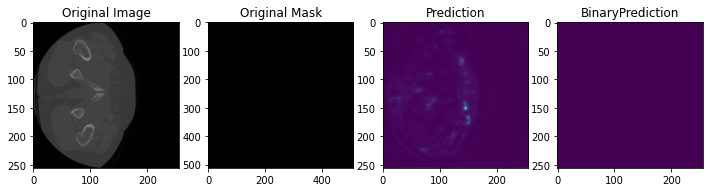


Similarity between two images is 0.9999998719085633
#########################################

1/1 [==============================] - 0s 24ms/step
The latency of the prediction is 78.40466499328613ms



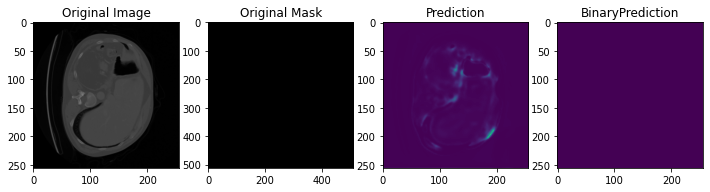


Similarity between two images is 0.999999679030112
#########################################

1/1 [==============================] - 0s 24ms/step
The latency of the prediction is 110.46719551086426ms



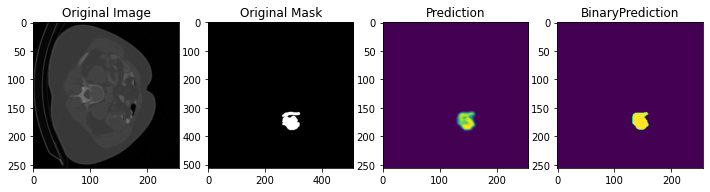


Similarity between two images is 0.9782341468013317
#########################################

1/1 [==============================] - 0s 25ms/step
The latency of the prediction is 111.61231994628906ms



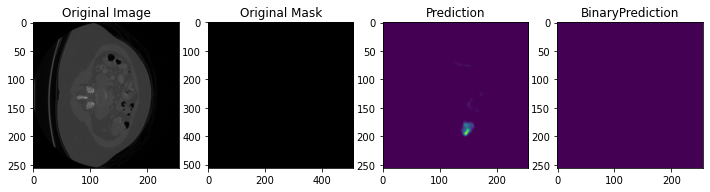


Similarity between two images is 0.9963214712666563
#########################################

1/1 [==============================] - 0s 25ms/step
The latency of the prediction is 76.27272605895996ms



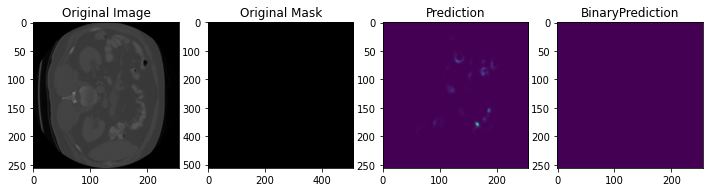


Similarity between two images is 0.9999542807775026
#########################################

1/1 [==============================] - 0s 25ms/step
The latency of the prediction is 113.55757713317871ms



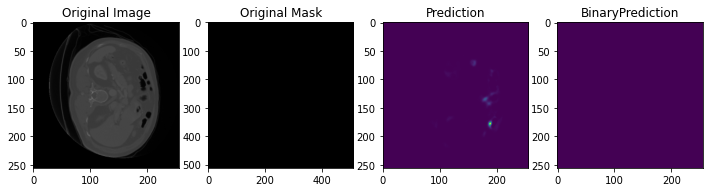


Similarity between two images is 0.999926505328996
#########################################

1/1 [==============================] - 0s 37ms/step
The latency of the prediction is 109.90118980407715ms



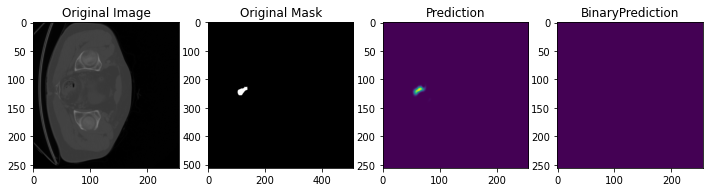


Similarity between two images is 0.9927111844166233
#########################################

1/1 [==============================] - 0s 25ms/step
The latency of the prediction is 110.53180694580078ms



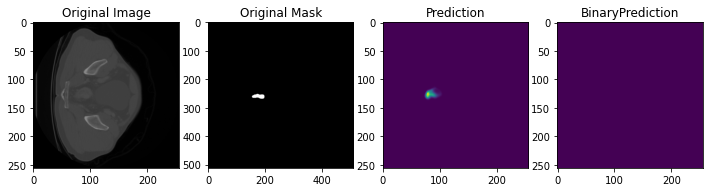


Similarity between two images is 0.9917591403449993
#########################################

1/1 [==============================] - 0s 26ms/step
The latency of the prediction is 79.31733131408691ms



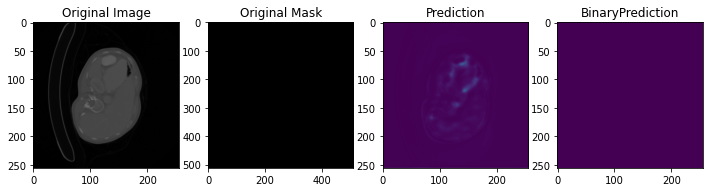


Similarity between two images is 0.9999999134950888
#########################################

1/1 [==============================] - 0s 26ms/step
The latency of the prediction is 111.6793155670166ms



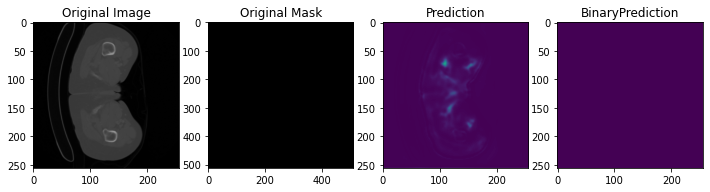


Similarity between two images is 0.9999998240128514
#########################################



In [102]:
for i in range(10):
  idx = random.randint(0,len(imagemask_df))
    
  image = cv2.imread(image_slicepath +'/'+ imagemask_df['slice_images'][idx])
  mask = cv2.imread(masks_slicepath +'/'+ imagemask_df['slice_masks'][idx])
    
  img = cv2.resize(image,(ImgHeight,ImgWidth))
  msk = cv2.resize(mask,(ImgHeight,ImgWidth))
  img_gray = cv2.cvtColor(msk,cv2.COLOR_BGR2GRAY)
  img = img/255
  img = img[np.newaxis,:,:,:]
  start_time=time.time()
  pred=my_model.predict(img)
  print("The latency of the prediction is " + str((time.time()-start_time)*1000)+"ms\n")
  k = np.squeeze(pred)
  plt.figure(figsize=(12,12))
  plt.subplot(1,4,1)
  plt.imshow(np.squeeze(img))
  plt.title('Original Image')
  plt.subplot(1,4,2)
  plt.imshow(mask)
  plt.title('Original Mask')
  plt.subplot(1,4,3)
  plt.imshow(np.squeeze(pred))
  plt.title('Prediction')
  plt.subplot(1,4,4)
  plt.imshow(np.squeeze(pred) > 0.5)
  plt.title('BinaryPrediction')
  plt.show()
  print("\nSimilarity between two images is " + str(ssim(k,img_gray)))
  print("#########################################\n")

## Test data

1/1 [==============================] - 0s 29ms/step
The latency of the prediction is 75.05154609680176ms



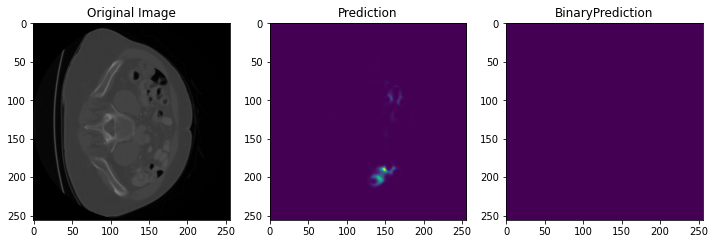


#########################################

1/1 [==============================] - 0s 25ms/step
The latency of the prediction is 114.78662490844727ms



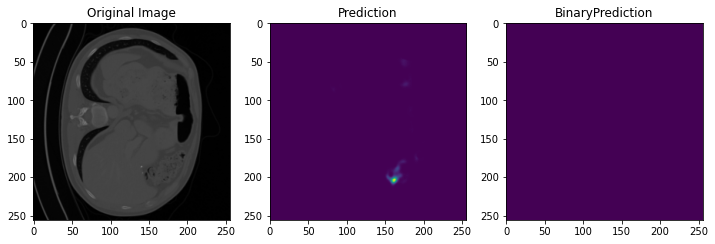


#########################################

1/1 [==============================] - 0s 26ms/step
The latency of the prediction is 74.10645484924316ms



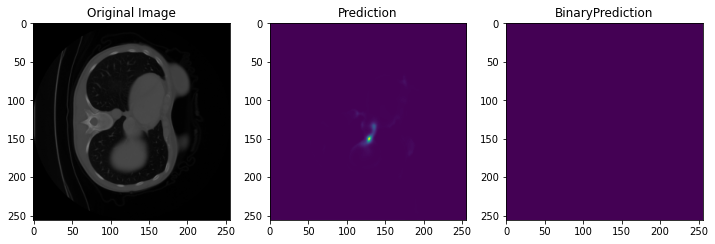


#########################################

1/1 [==============================] - 0s 27ms/step
The latency of the prediction is 115.88668823242188ms



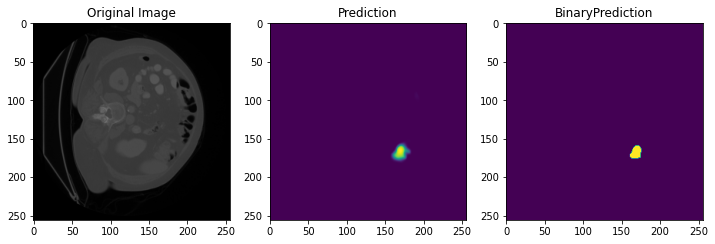


#########################################

1/1 [==============================] - 0s 26ms/step
The latency of the prediction is 115.59438705444336ms



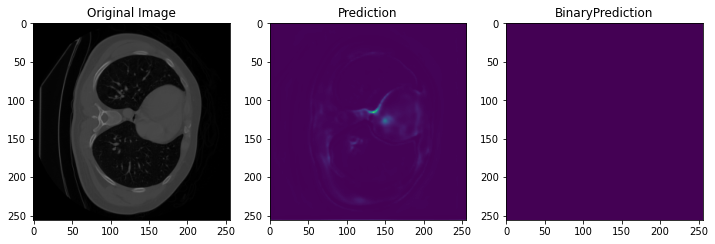


#########################################

1/1 [==============================] - 0s 24ms/step
The latency of the prediction is 116.51182174682617ms



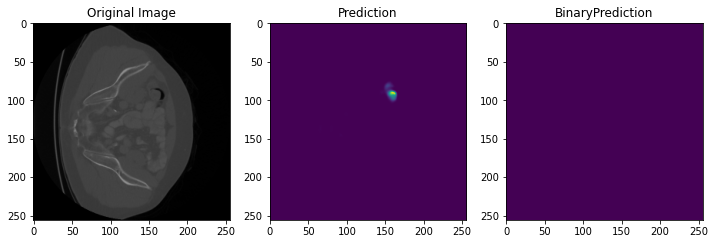


#########################################

1/1 [==============================] - 0s 27ms/step
The latency of the prediction is 82.67021179199219ms



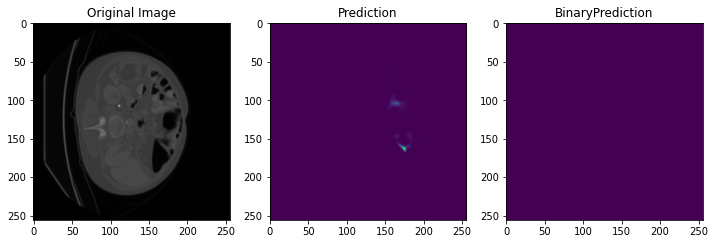


#########################################

1/1 [==============================] - 0s 28ms/step
The latency of the prediction is 79.68020439147949ms



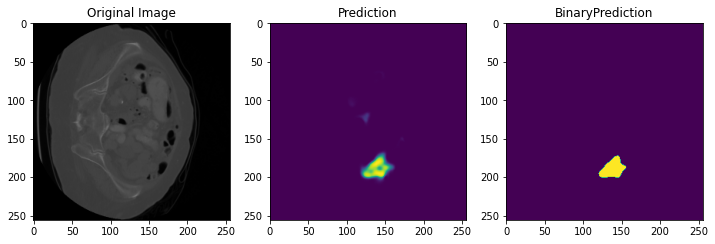


#########################################

1/1 [==============================] - 0s 25ms/step
The latency of the prediction is 118.60060691833496ms



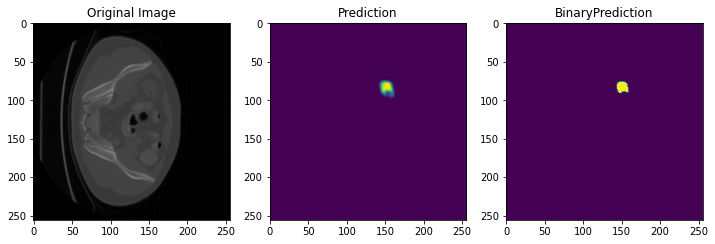


#########################################

1/1 [==============================] - 0s 26ms/step
The latency of the prediction is 115.54360389709473ms



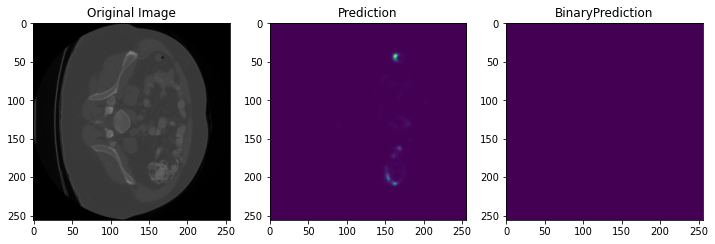


#########################################



In [105]:
for i in range(10):
  idx = random.randint(0,len(test_image_df))
    
  image = cv2.imread(test_imageSliceOutput +'/'+ test_image_df['slice_test_images'][idx])
  #mask = cv2.imread(masks_slicepath +'/'+ imagemask_df['slice_masks'][idx])
    
  img = cv2.resize(image,(ImgHeight,ImgWidth))
  #msk = cv2.resize(mask,(ImgHeight,ImgWidth))
  #img_gray = cv2.cvtColor(msk,cv2.COLOR_BGR2GRAY)
  img = img/255
  img = img[np.newaxis,:,:,:]
  start_time=time.time()
  pred=my_model.predict(img)
  print("The latency of the prediction is " + str((time.time()-start_time)*1000)+"ms\n")
  k = np.squeeze(pred)
  plt.figure(figsize=(12,12))
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(img))
  plt.title('Original Image')
  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(pred))
  plt.title('Prediction')
  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(pred) > 0.5)
  plt.title('BinaryPrediction')
  plt.show()
  print("\n#########################################\n")

# Prediction on 3d data

## Preprocessing the input

In [81]:
trimage_3d = "/content/content/drive/MyDrive/project/Task10_Colon/imagesTr"
trmask_3d = "/content/content/drive/MyDrive/project/Task10_Colon/labelsTr"
tsimage_3d = "/content/content/drive/MyDrive/project/Task10_Colon/imagesTs"

In [82]:
def fil_name(path):
  files = []
  for f in os.listdir(path):
    if f.startswith('colon_'):
        files.append(f)
  return files

In [83]:
trimages = fil_name(trimage_3d)
trmasks = fil_name(trmask_3d)
tsimages = fil_name(tsimage_3d)


In [84]:
len(trimages),len(trmasks),len(tsimages)

(126, 126, 64)

##Converting the test images to dataframe

In [108]:
tr_image3d_df = pd.DataFrame({'tr_images':trimages})
tr_image3d_df.head()

,tr_images
0,colon_100.nii.gz
1,colon_038.nii.gz
2,colon_207.nii.gz
3,colon_098.nii.gz
4,colon_149.nii.gz


In [109]:
tr_mask3d_df = pd.DataFrame({'tr_masks':trmasks})
tr_mask3d_df.head()

,tr_masks
0,colon_100.nii.gz
1,colon_038.nii.gz
2,colon_207.nii.gz
3,colon_098.nii.gz
4,colon_149.nii.gz


In [110]:
ts_image3d_df = pd.DataFrame({'ts_images':tsimages})
ts_image3d_df.head()

,ts_images
0,colon_198.nii.gz
1,colon_116.nii.gz
2,colon_083.nii.gz
3,colon_090.nii.gz
4,colon_070.nii.gz


## Custom function for predicting every layer in 3d data

In [111]:
def predictVolume(inImg, toBin=True):
    (xMax, yMax, zMax) = inImg.shape
    
    outImgX = np.zeros((xMax, yMax, zMax))
    outImgY = np.zeros((xMax, yMax, zMax))
    outImgZ = np.zeros((xMax, yMax, zMax))
    r_time = []
    cnt = 0.0
    if SLICE_Z:
        cnt += 1.0
        for i in range(zMax):
            img = np.uint8(inImg[:,:,i] * 255)
            fout = os.path.join("/content/temp",'temp.png')
            cv2.imwrite(fout,img)
            img = cv2.imread("/content/temp/temp.png")
            img = img/255
            img = img[np.newaxis,:,:]
            start_time = time.time()
            pred = my_model.predict(img)
            end_time = time.time()
            r_time.append(end_time-start_time)
            k = np.squeeze(pred)
            outImgZ[:,:,i] = cv2.resize(k,(xMax,yMax))
            
    outImg = (outImgX + outImgY + outImgZ)/cnt
    if(toBin):
        outImg[outImg>0.5] = 1.0
        outImg[outImg<=0.5] = 0.0
    print("The latency of the predictions is :"+ str(np.mean(r_time)*1000)+"ms")    
    return outImg

In [117]:
idx = random.randint(0,len(tr_image3d_df))
imgPath = trimage_3d +'/'+ tr_image3d_df ['tr_images'][idx]
imgTarget = readImageVolume(imgPath, normalize=True)

In [118]:
predImg = predictVolume(imgTarget)

1/1 [==============================] - 0s 27ms/step
The latency of the predictions is :107.30492828676365ms


In [119]:
#idx = random.randint(0,len(tr_mask3d_df))
mskPath = trmask_3d +'/'+ tr_mask3d_df ['tr_masks'][idx]
imgMaskNii = nib.load(mskPath)
my_widget = NiftiWidget(imgMaskNii)
my_widget.nifti_plotter(colormap='gray')


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=255, continuous_update=False, description='x', max=511), IntSlider(value…

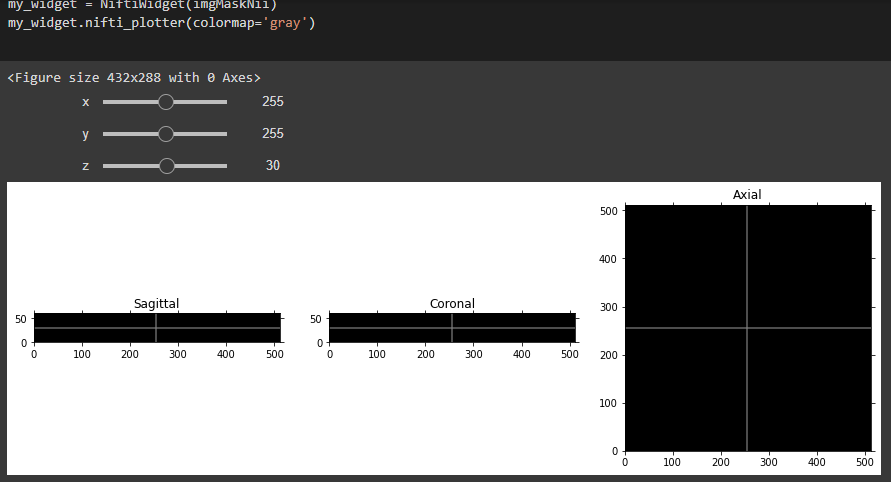

In [ ]:
from IPython.display import Image
Image(filename='MaskNii.PNG')


## Final 3d Prediction

In [120]:
my_widget = NiftiWidget(nib.dataobj_images.DataobjImage(predImg))
my_widget.nifti_plotter(colormap='gray')

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=255, continuous_update=False, description='x', max=511), IntSlider(value…

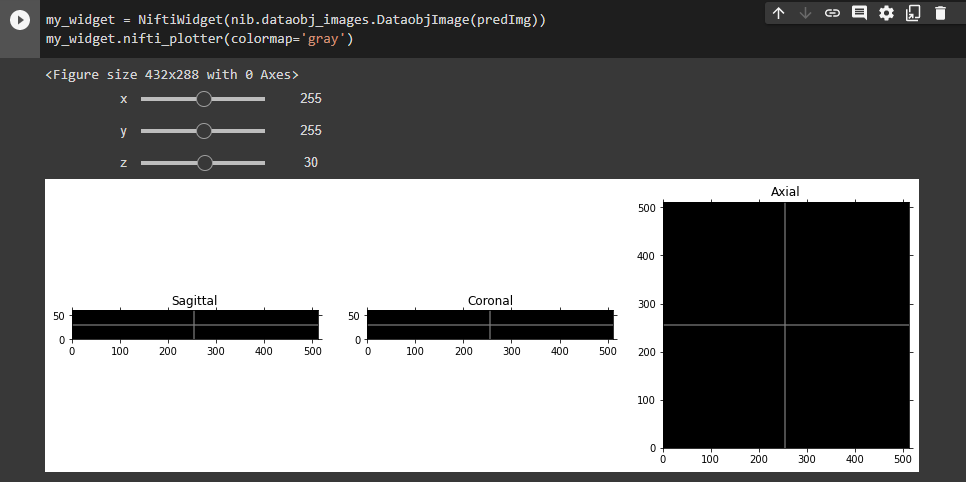

In [ ]:
from IPython.display import Image
Image(filename='Predict.PNG')
